In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

from sklearn.impute import KNNImputer

import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval
from hyperopt.pyll import scope

## 1. Loading the dataset

In [2]:
train_df = pd.read_csv("./playground-series-s3e22/train.csv")
test_df = pd.read_csv("./playground-series-s3e22/test.csv")
originial_df = pd.read_csv("./playground-series-s3e22/horse.csv")

train_df.shape, test_df.shape, originial_df.shape

((1235, 29), (824, 28), (299, 28))

In [3]:
train_df = pd.concat([train_df, originial_df], ignore_index=True)
train_df.drop_duplicates(inplace=True)
train_df.shape

(1534, 29)

## 2. EDA

In [4]:
train_df.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0.0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1.0,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2.0,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3.0,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4.0,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


There are 3 possible outcomes of each horse treatment: euthanized, lived, died

In [5]:
def summary(df: pd.DataFrame):
    
    summary = pd.DataFrame()
    summary['types'] = df.dtypes
    summary['unique_count'] = df.nunique().values
    summary['missing_values']= df.isna().sum()
    summary['count'] = df.count().values
    
    return summary

cell_hover = {
    'selector': 'td:hover',
    'props': 'background-color: #ffffb3; color: black'
}
    
summary(train_df).style.background_gradient(cmap='Oranges') \
                        .set_caption("Train data summary") \
                        .format_index(str.upper, axis=1) \
                        .set_table_styles([cell_hover]) #type: ignore
                    


,TYPES,UNIQUE_COUNT,MISSING_VALUES,COUNT
id,float64,1235,299,1235
surgery,object,2,0,1534
age,object,2,0,1534
hospital_number,int64,288,0,1534
rectal_temp,float64,43,60,1474
pulse,float64,52,24,1510
respiratory_rate,float64,40,58,1476
temp_of_extremities,object,5,56,1478
peripheral_pulse,object,5,69,1465
mucous_membrane,object,7,47,1487


In [6]:
summary(test_df).style.background_gradient(cmap='Oranges') \
                        .set_caption("Test data summary") \
                        .format_index(str.upper, axis=1) \
                        .set_table_styles([cell_hover]) #type: ignore

,TYPES,UNIQUE_COUNT,MISSING_VALUES,COUNT
id,int64,824,0,824
surgery,object,2,0,824
age,object,2,0,824
hospital_number,int64,210,0,824
rectal_temp,float64,34,0,824
pulse,float64,49,0,824
respiratory_rate,float64,38,0,824
temp_of_extremities,object,5,0,824
peripheral_pulse,object,5,0,824
mucous_membrane,object,7,0,824


## 2.1 Dataset distribution for categorical columns

In [7]:
# Columns to encode with 2 unique values
cols_with_binary_values = train_df[[col for col in train_df.columns if train_df[col].nunique() == 2]].columns

In [58]:
# Columns to encode with more than 2 unique options
cols_with_more_than_3_values = train_df[[col for col in train_df.columns if (train_df[col].nunique() > 2 and
                                     col != "outcome" and
                                     train_df[col].nunique() < 8)]].columns
cols_with_more_than_3_values

Index(['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention',
       'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces',
       'abdomen', 'abdomo_appearance', 'lesion_2'],
      dtype='object')

In [59]:
def count_plots_dist(df: pd.DataFrame, columns, hue, n_cols = 3):
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows), dpi=200)
    ax = ax.flatten()
    
    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i], hue=hue, alpha=0.8, palette="Oranges")

        # Titles
        ax[i].set_title(f'{column} Counts', fontsize=18)
        
        # Removing row titles
        ax[i].set_xlabel(None, fontsize=16)
        ax[i].set_ylabel(None, fontsize=16)
        
        # Rotating labels for readability
        ax[i].tick_params(axis='x', rotation=10)

        for p in ax[i].patches:
            value = int(p.get_height())
            ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='bottom', fontsize=9)

        ylim_top = ax[i].get_ylim()[1]
        ax[i].set_ylim(top=ylim_top * 1.1)
        
    for i in range(len(columns), len(ax)):
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

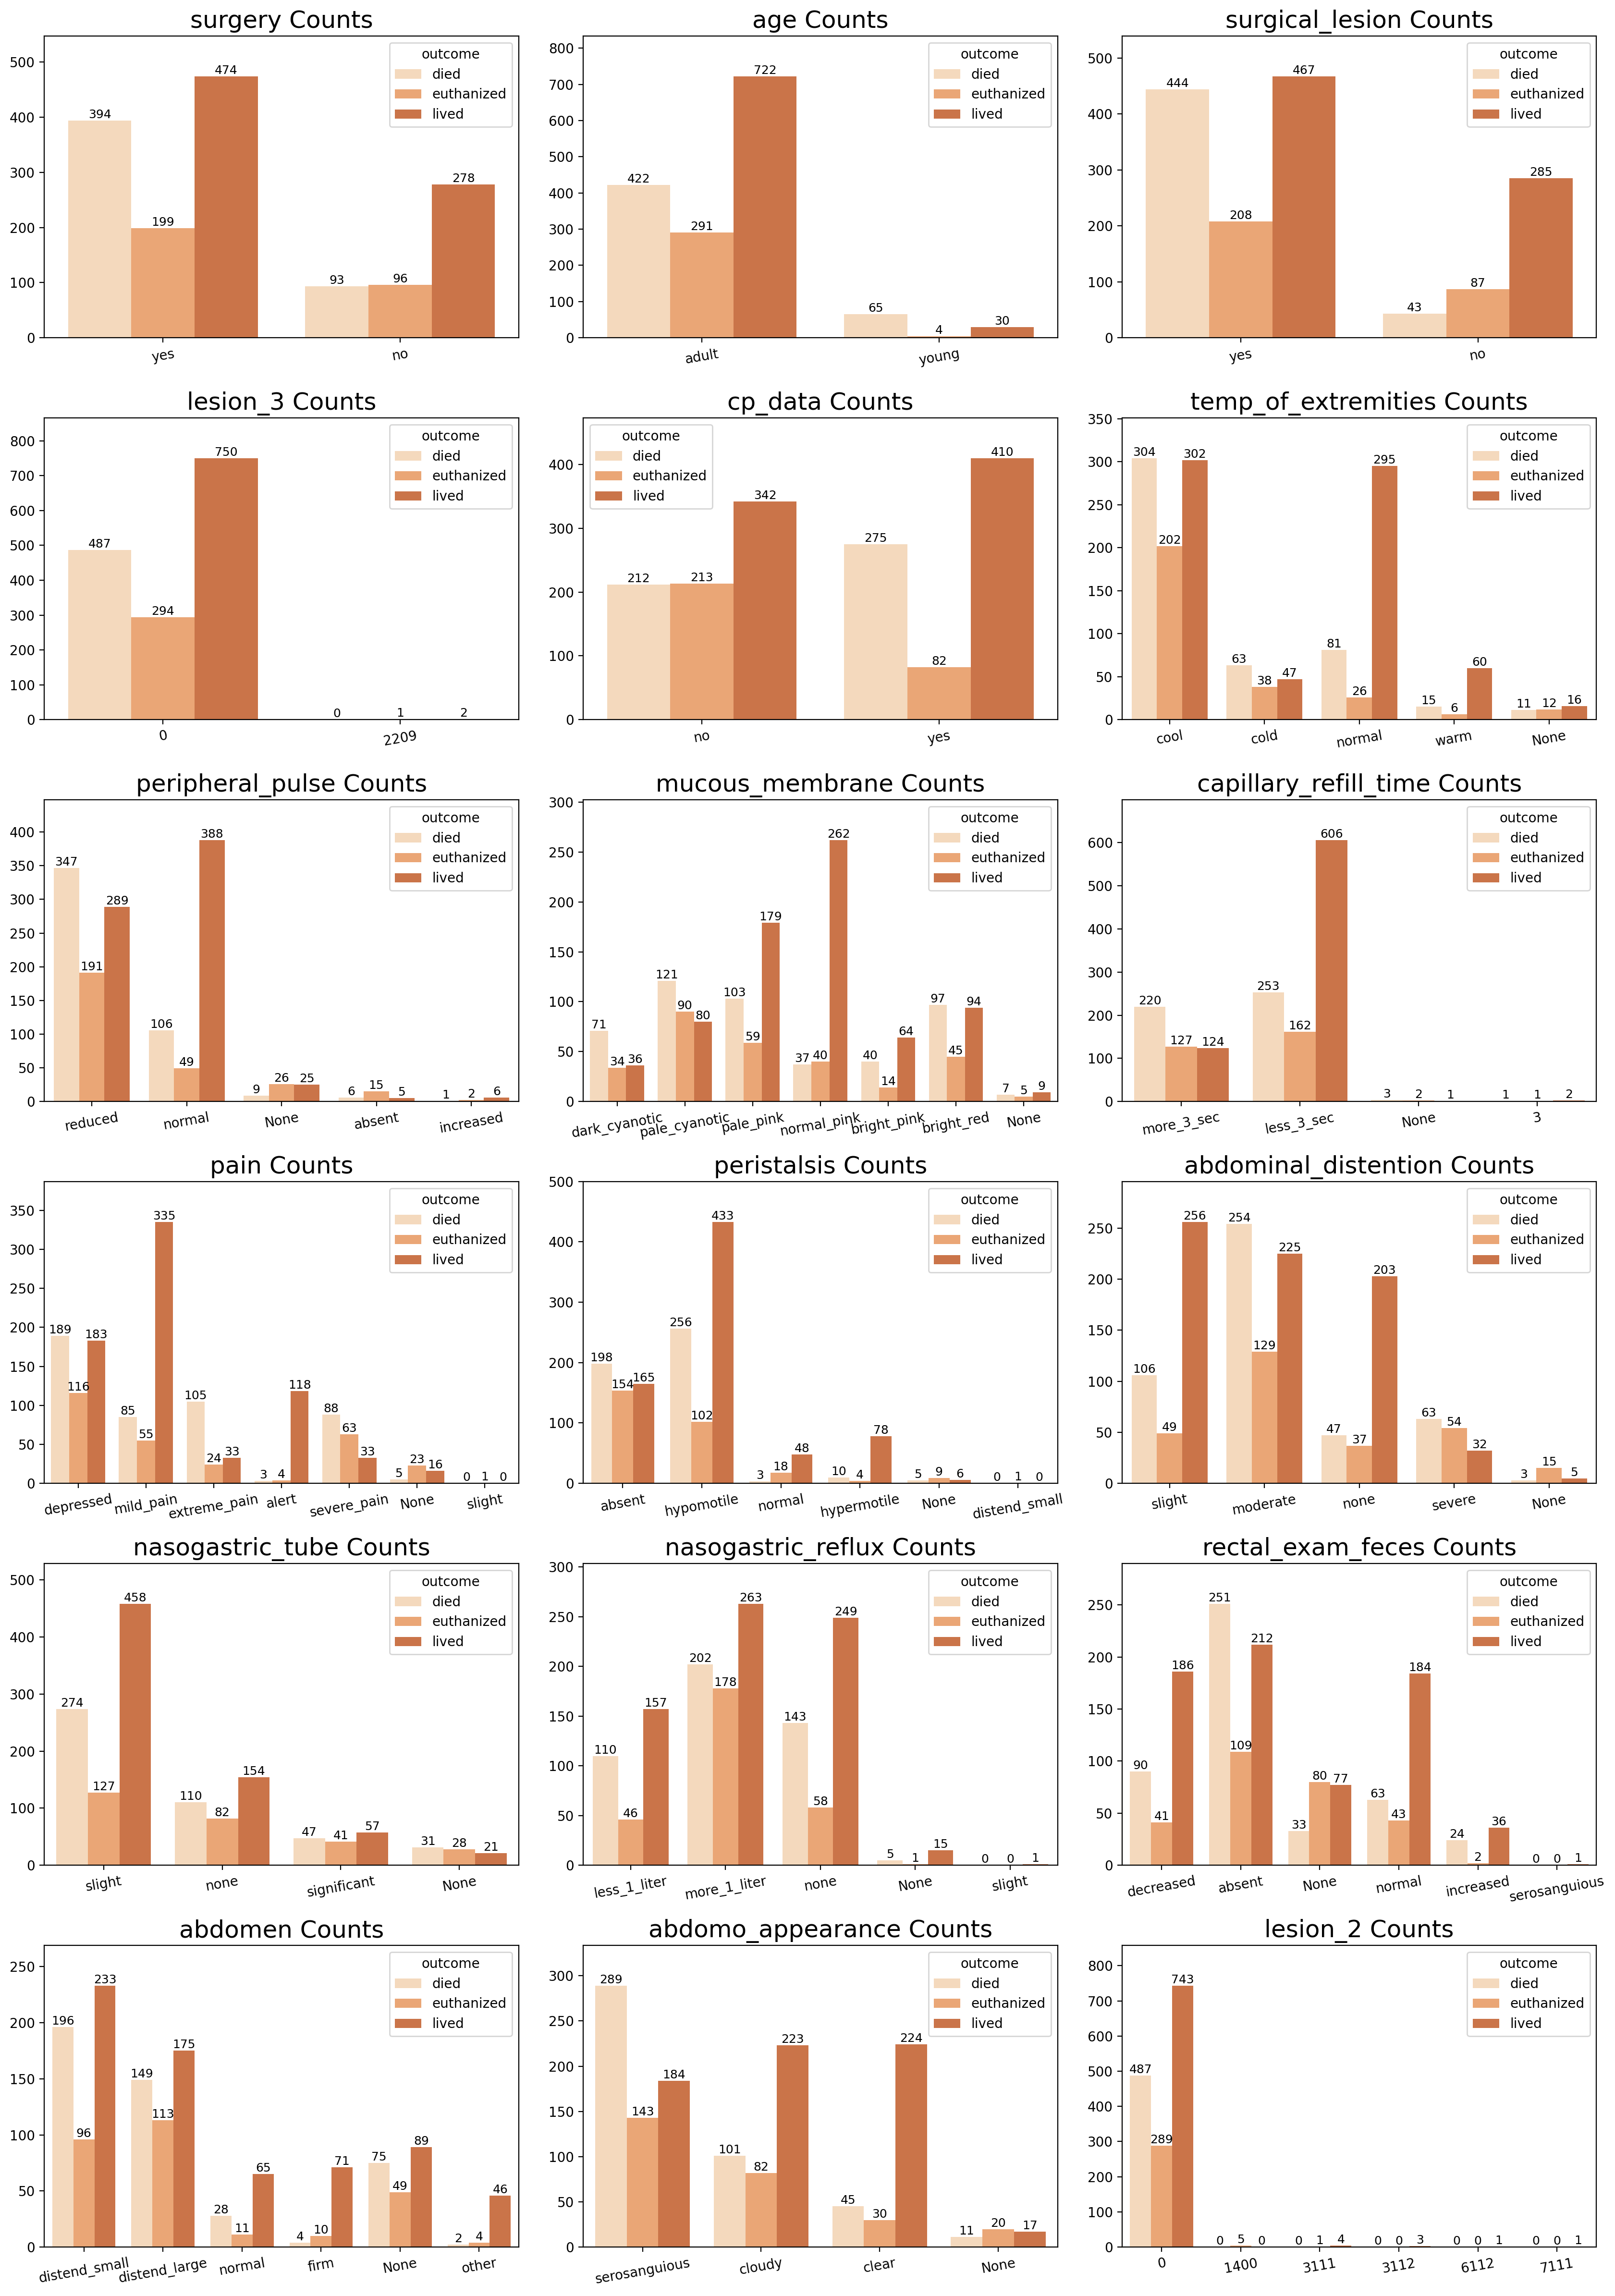

In [60]:
# Train data
cat_cols = np.concatenate((cols_with_binary_values, cols_with_more_than_3_values))
count_plots_dist(train_df, cat_cols, 'outcome')

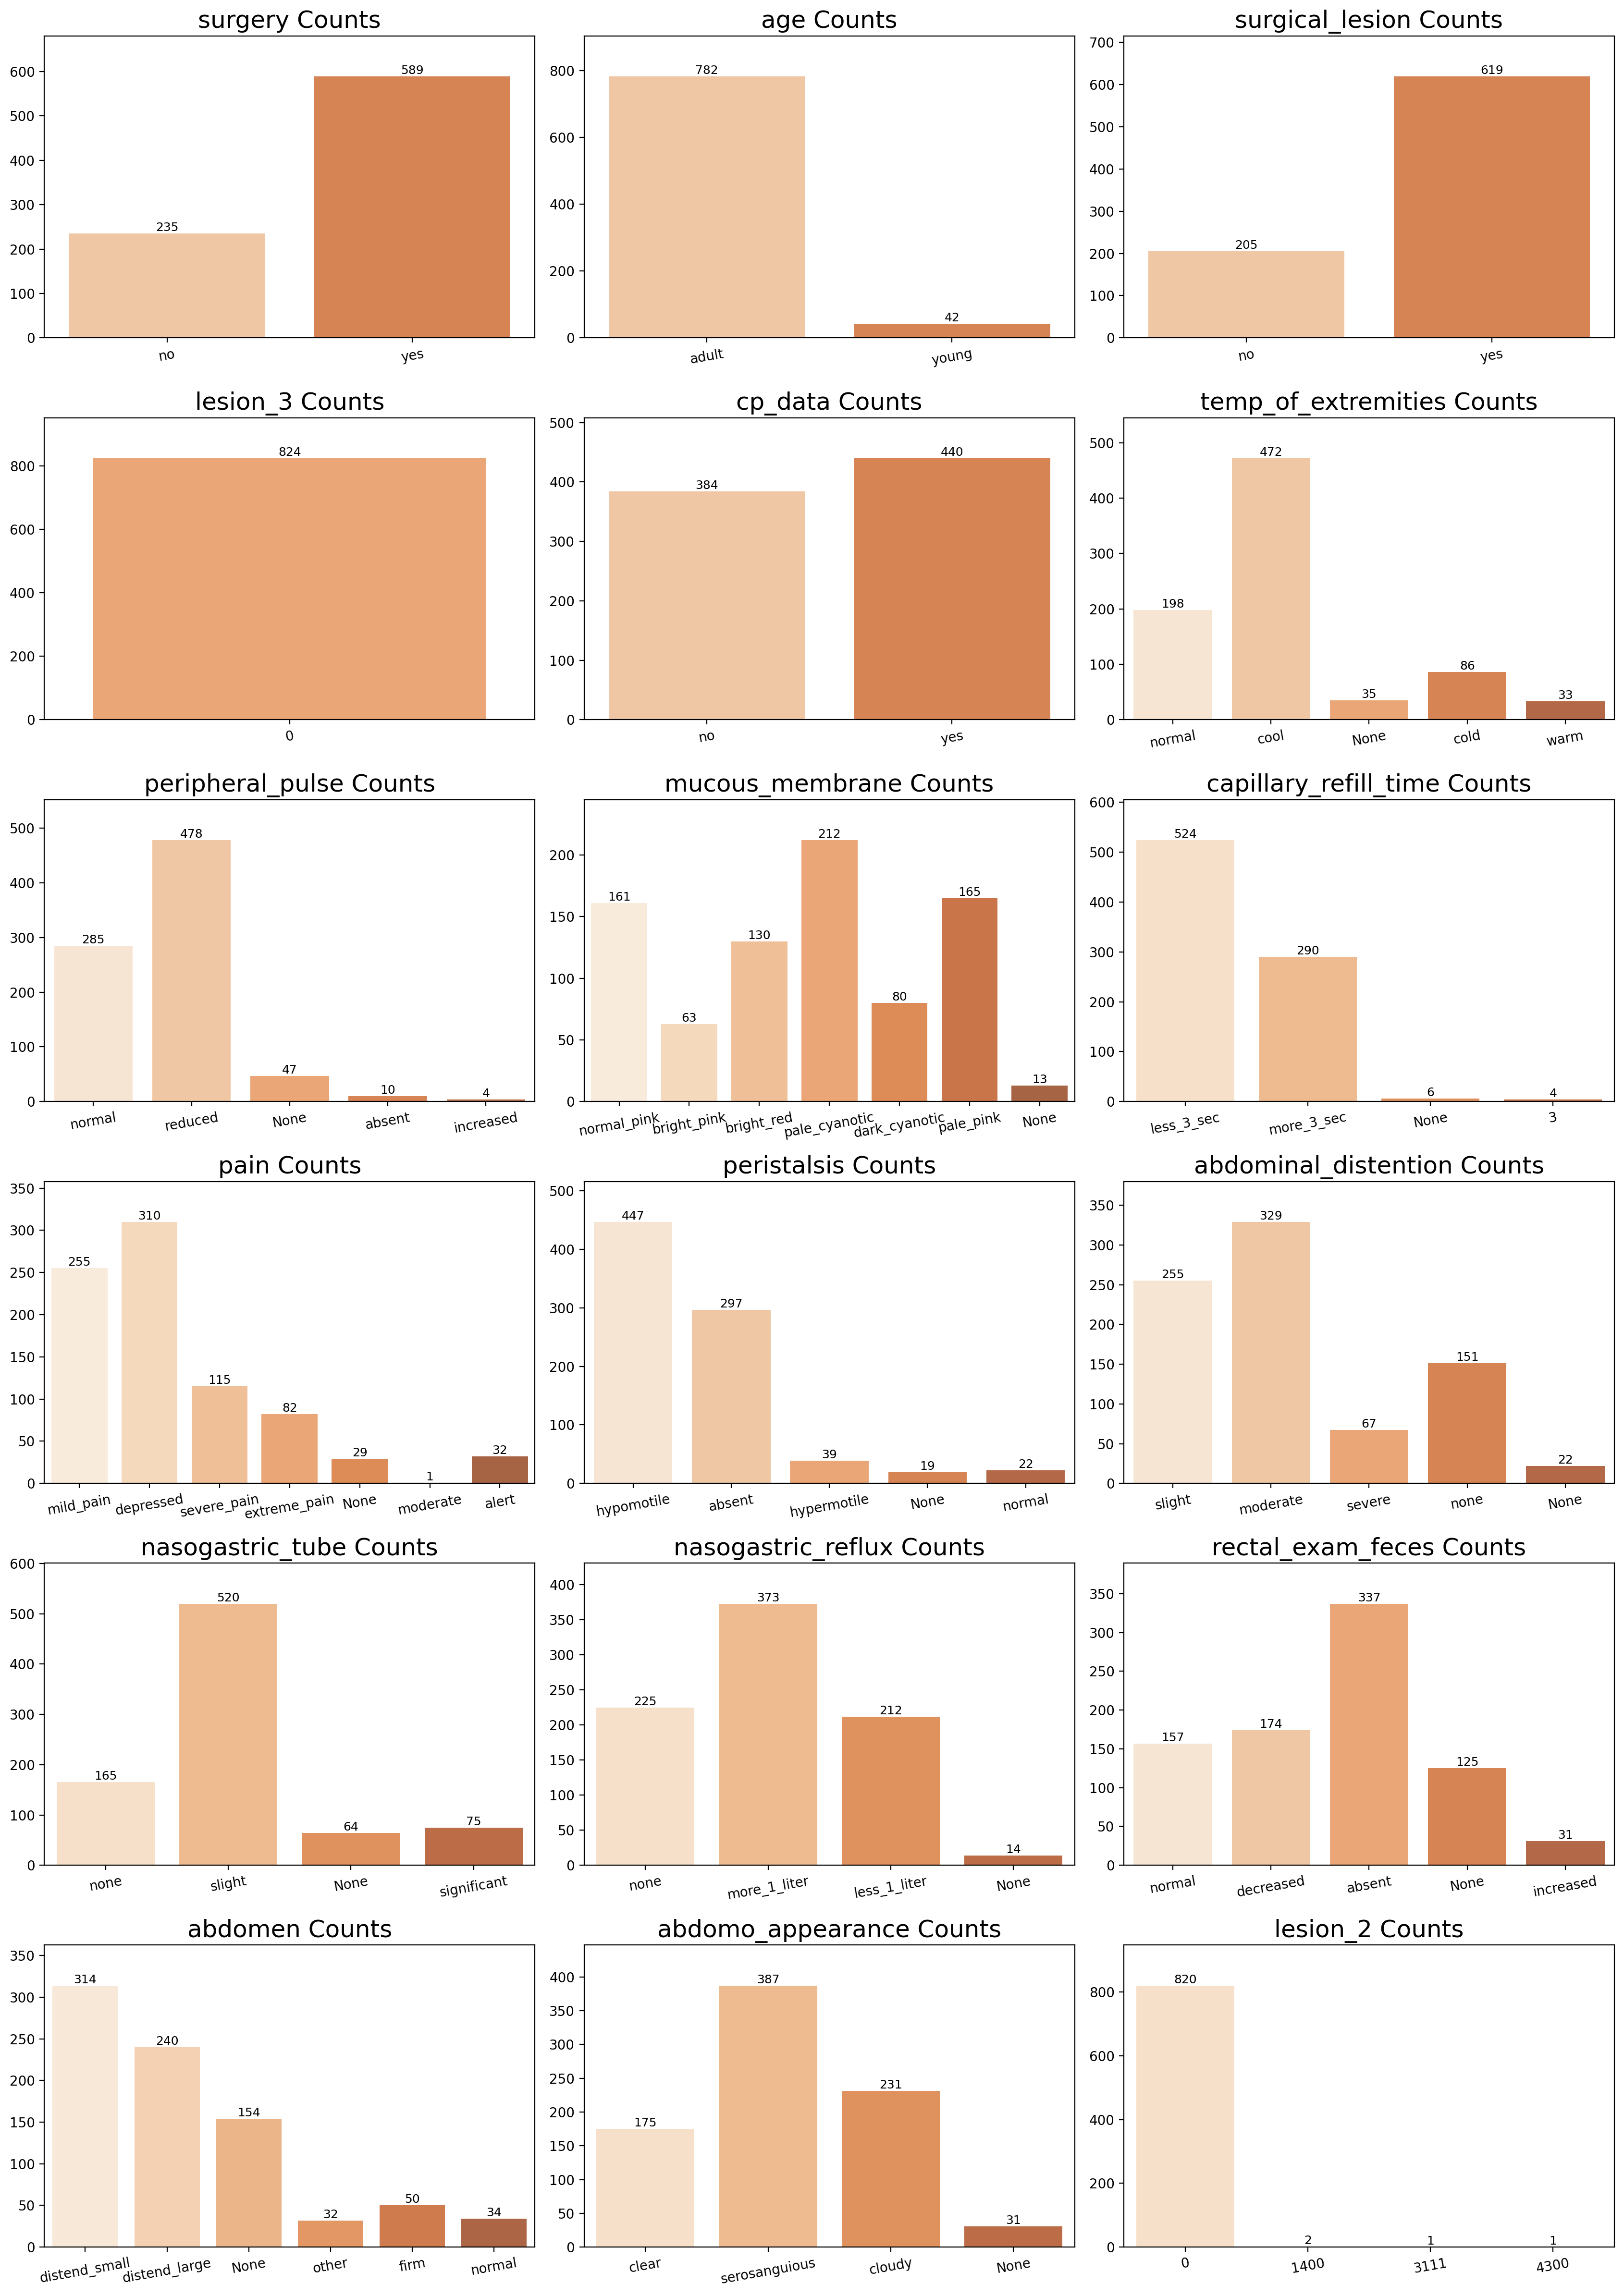

In [61]:
# Test data
count_plots_dist(test_df, cat_cols, None)

**Notes:**
* There is an imbalance in the age columns since it mostly comprises of adults
* Periphral pulse contains very little 'absent' and 'increased' values
* 'capillary_refill_time' very small number of 3 values
* 'lesion_2' and 'lesion_3' carry no useful information

## 2.2 Correlation matrix

<ipython-input-62-1a1de0dc90ea>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df[list(train_df.columns)].corr()


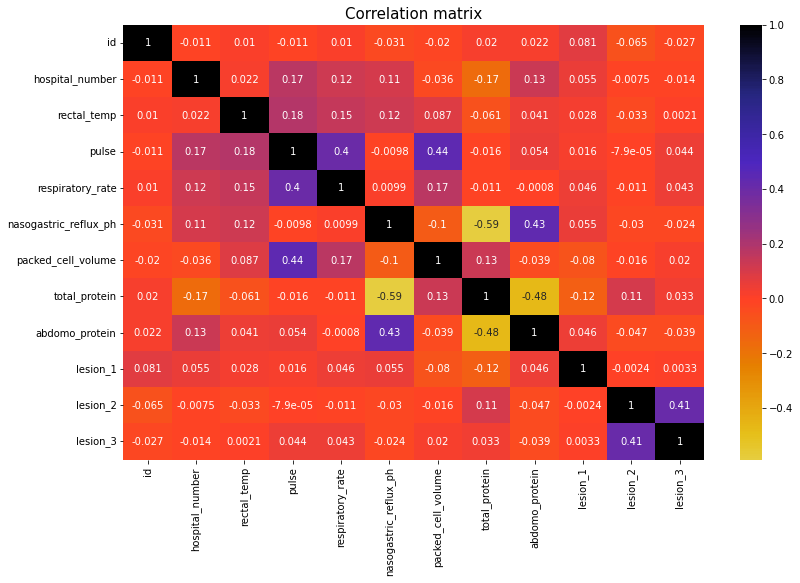

In [62]:
corr = train_df[list(train_df.columns)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap=plt.cm.CMRmap_r , annot = True, center = 0)
plt.title('Correlation matrix', fontsize = 15)
plt.show()


In [63]:
# Finding columns with singlar unique value
for col in cols_with_more_than_3_values:
    potential_value = train_df[col].value_counts().loc[train_df[col].value_counts() == 1]
    if len(potential_value) > 0:
        print(potential_value)
    

slight    1
Name: pain, dtype: int64
distend_small    1
Name: peristalsis, dtype: int64
slight    1
Name: nasogastric_reflux, dtype: int64
serosanguious    1
Name: rectal_exam_feces, dtype: int64
7111    1
6112    1
Name: lesion_2, dtype: int64


In [64]:
numerical_columns = train_df[[col for col in train_df.columns if train_df[col].dtype==np.float64]].columns

## 3. Data preprocessing

In [65]:

def preprocess_df(df: pd.DataFrame, test_set: bool):
    df.copy()
    # 1. Binary encoding
    columns_to_binary_encode_yesno = ["surgery", "surgical_lesion", "cp_data"]
    for col in columns_to_binary_encode_yesno: 
        df[col] = df[col].eq("yes").mul(1)
    
    df["age"] = df["age"].eq("adult").mul(1)
    
    # 2. Remapping outcomes
    outcomes = {'lived': 0,
                'died': 1, 
                'euthanized': 2}

    if not test_set:
        df['outcome'] = df['outcome'].map(outcomes) 
        
    # 4. Encoding categorical features
    
    df["pain"] = df["pain"].replace("slight", "moderate")
    df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
    df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
    df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')
    
    # Mapping categorical features
    df["temp_of_extremities"] = df["temp_of_extremities"].map({'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3, 'None': 2})
    df["peripheral_pulse"] = df["peripheral_pulse"].map({'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3, 'None': 2})
    df["capillary_refill_time"] = df["capillary_refill_time"].map({'less_3_sec': 0, '3': 1, 'more_3_sec': 2, 'None': 1})
    df["pain"] = df["pain"].map({'alert': 0, 'depressed': 1, 'moderate': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5, 'None': 1})
    df["peristalsis"] = df["peristalsis"].map({'hypermotile': 0, 'normal': 1, 'hypomotile': 2, 'absent': 3, 'None': 1})
    df["abdominal_distention"] = df["abdominal_distention"].map({'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3, 'None': 0})
    df["nasogastric_tube"] = df["nasogastric_tube"].map({'none': 0, 'slight': 1, 'significant': 2, 'None': 0})
    df["nasogastric_reflux"] = df["nasogastric_reflux"].map({'less_1_liter': 0, 'none': 1, 'more_1_liter': 2, 'None': 1})
    df["rectal_exam_feces"] = df["rectal_exam_feces"].map({'absent': 0, 'decreased': 1, 'normal': 2, 'increased': 3, 'None': 0})
    df["abdomen"] = df["abdomen"].map({'normal': 0, 'other': 1, 'firm': 2,'distend_small': 3, 'distend_large': 4, 'None': 3})
    df["abdomo_appearance"] = df["abdomo_appearance"].map({'clear': 0, 'cloudy': 1, 'serosanguious': 2, 'None': 2})
    
    
    # 6. Dropping rows with missing mucous_membrane
    df = df.dropna(subset=['mucous_membrane'])
    
    # 7. One hot encoding additional column
    df= pd.get_dummies(df, columns=["mucous_membrane"])
    
    # 8. Imputing missing values
    imputer = KNNImputer(n_neighbors=2)
    imputed = imputer.fit_transform(df)
    imputed_df = pd.DataFrame(imputed, columns=df.columns)
    
    # Columns with categorical data     
    cols_with_categorical_data = np.concatenate((cols_with_binary_values, cols_with_more_than_3_values))
    cols_with_categorical_data = np.delete(cols_with_categorical_data, np.where(cols_with_categorical_data == 'mucous_membrane'))
    
    # Rounding imputed values to represent nearest categorical data labels
    imputed_df[cols_with_categorical_data] = imputed_df[cols_with_categorical_data].apply(lambda x: round(x))
    
    df = imputed_df
    

    # 9. Dropping correlated dependent feature
    df.drop('lesion_3',axis=1,inplace=True)
        
    return df
    

In [66]:
def scale_features(df):
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns]) 
    
    return df
    

In [67]:
preprocessed_df = preprocess_df(train_df, False)


In [75]:
(preprocessed_df["nasogastric_reflux"] == 'none').value_counts()

False    1487
Name: nasogastric_reflux, dtype: int64

In [ ]:
# preprocessed_df = scale_features(preprocessed_df)

In [76]:
cols_with_missing_values = preprocessed_df.columns[preprocessed_df.isnull().any()]
cols_with_missing_values

Index([], dtype='object')

All missing values have been filled

In [77]:
preprcessed_test_df = preprocess_df(test_df, True)

In [ ]:
# preprcessed_test_df = scale_features(preprcessed_test_df)

In [78]:
X = preprocessed_df.drop(["outcome", "id"], axis=1)
y = preprocessed_df["outcome"]

In [79]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42) 
kf = KFold(n_splits=8)

## 4. Modelling 1.0

### 4.1 XGB (default)

In [ ]:
f1_scores_xgb = []

model__xgb_default = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror', 'mlogloss'], 
                            seed=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model__xgb_default.fit(X_train, 
                y_train,
                verbose=0,
                eval_set=[(X_train, y_train), (X_test, y_test)])
    
    xgb_def_preds = model__xgb_default.predict(X_test)
    
    f1_scores_xgb.append(f1_score(y_test, xgb_def_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_xgb)))


#### Tuning

In [ ]:
# Define the hyperparameter space
space = {
    'max_depth': scope.int(hp.quniform('max_depth', 2, 8, 1)),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Define the objective function to minimize
def objective(params):
    xgb_model = xgb.XGBClassifier(objective='multi:softmax', 
                                  num_class=3,
                                  **params,
                                  seed=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

#### Tuned

In [ ]:
f1_scores_xgb_tuned = []

model_xgb_tuned = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror', 'mlogloss'], 
                            learning_rate=0.0929001213267843,
                            max_depth=7,
                            subsample=0.5165249283838895,
                            seed=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model_xgb_tuned.fit(X_train, 
                y_train,
                verbose=0,
                eval_set=[(X_train, y_train), (X_test, y_test)])
    
    xgb_def_preds = model_xgb_tuned.predict(X_test)
    
    f1_scores_xgb_tuned.append(f1_score(y_test, xgb_def_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_xgb_tuned)))

After tuning the average F1 Score increased by 1

### 4.2 CatBoost


In [ ]:

f1_scores_cat = []

cat_md = CatBoostClassifier(loss_function = 'MultiClass',
                                    iterations = 500,
                                    verbose = False, 
                                    task_type = 'GPU',
                                    random_seed=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    cat_md.fit(X_train, y_train)

    cat_pred = cat_md.predict(X_test) 
    
    f1_scores_cat.append(f1_score(y_test, cat_pred, average='micro'))
    
print("Average model F1 score: {}".format(np.average(f1_scores_cat)))

#### Tuning

In [ ]:
# define the search space for the hyperparameters
space = {'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
         'iterations': hp.randint('iterations',100,1000),
         'l2_leaf_reg': hp.randint('l2_leaf_reg',1,10),
         'depth': hp.randint('depth',4,10)}

# define the objective function which for this model is the RMSE
def objective(search_space):
    model = CatBoostClassifier(**search_space,
                              loss_function='MultiClass',
                              early_stopping_rounds=100,
                              task_type = 'GPU',
                              random_seed=42)
    
    model.fit(X = X_train, y = y_train, verbose=False)
    y_pred = model.predict(X_test)
    score = f1_score(y_pred, y_test, average='micro')
    return {'loss': -score, 'status': STATUS_OK}

In [ ]:
# search for best parameters
best_params = fmin(
  fn=objective,
  space=space,
  algo=tpe.suggest,
  max_evals=50)

In [ ]:
# dict of the best params
hyperparams = space_eval(space, best_params)
hyperparams

#### Tuned

In [ ]:

f1_scores_cat_tuned = []

cat_md_tuned = CatBoostClassifier(loss_function = 'MultiClass',
                                    iterations = 594,
                                    verbose = False, 
                                    task_type = 'GPU',
                                    early_stopping_rounds=100,
                                    depth=8,
                                    l2_leaf_reg=4,
                                    learning_rate=0.2805333293875,
                                    random_seed=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    cat_md_tuned.fit(X_train, y_train)

    cat_pred = cat_md_tuned.predict(X_test) 
    
    f1_scores_cat_tuned.append(f1_score(y_test, cat_pred, average='micro'))
    
print("Average model F1 score: {}".format(np.average(f1_scores_cat_tuned)))

### 4.3 LightGBM

In [ ]:
f1_scores_lgb = []

model_lgb_default = LGBMClassifier(num_iterations=300,
                                   max_depth=10,
                                   objective='multiclass',
                                   verbose=-1)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_lgb_default.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.early_stopping(10, verbose=False)], verbose=False)
    
    lgb_preds = model_lgb_default.predict(X_test)
    
    f1_scores_lgb.append(f1_score(y_test, lgb_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_lgb)))

#### Tuning

In [ ]:
# Search space

space = {
        'num_leaves': scope.int(hp.quniform('num_leaves', 30, 150, 1)),
        'num_iterations': hp.randint('num_iterations', 100, 1000),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'subsample_for_bin': scope.int(hp.quniform('subsample_for_bin', 20000, 300000, 20000)),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1), #alias "subsample"
        'min_data_in_leaf': scope.int(hp.qloguniform('min_data_in_leaf', 1, 6, 1)),
        'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'verbose': -1,
        'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
    }



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def objective(search_space):
    model = LGBMClassifier(**search_space,
                            max_depth=8,
                            objective='multiclass',
                            random_seed=42)
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.early_stopping(10, verbose=False)], verbose=False)
    y_pred = model.predict(X_test)
    score = f1_score(y_pred, y_test, average='micro')
    return {'loss': -score, 'status': STATUS_OK}


In [ ]:
# search for best parameters
best_params = fmin(
  fn=objective,
  space=space,
  algo=tpe.suggest,
  max_evals=50)

In [ ]:
# dict of the best params
hyperparams = space_eval(space, best_params)
hyperparams

#### Tuned

In [ ]:
f1_scores_lgb_tuned = []

model_lgb_tuned = LGBMClassifier(num_iterations=252,
                                   max_depth=8,
                                   objective='multiclass',
                                   verbose=-1,
                                   bagging_fraction=0.7231034465658441,
                                   feature_fraction=0.5821614895839977,
                                   lambda_l1=5.427706788599808,
                                   lambda_l2=0.8044760526180615,
                                   learning_rate=0.06314706652404878,
                                   min_child_weight=0.0001701741731826891,
                                   min_data_in_leaf=45,
                                   num_leaves=63,
                                   subsample_for_bin=240000,
                                    )

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_lgb_tuned.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.early_stopping(10, verbose=False)], verbose=False)
    
    lgb_preds = model_lgb_tuned.predict(X_test)
    
    f1_scores_lgb_tuned.append(f1_score(y_test, lgb_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_lgb_tuned)))

After tuning the F1 score increased by 2

### 4.4 RandomForestClassifier

#### Default

In [ ]:
f1_scores_rfc_default = []

model_rfc_default = RandomForestClassifier(n_estimators=200,
                                           max_depth=7,
                                           verbose=0,
                                           random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_rfc_default.fit(X_train, y_train)
    
    rfc_preds = model_rfc_default.predict(X_test)
    
    f1_scores_rfc_default.append(f1_score(y_test, rfc_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_rfc_default)))

#### Tuning

In [ ]:
space = {
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_depth': hp.randint('max_depth', 5, 100),
    'max_features': hp.choice('max_features', ['auto', 'sqrt']),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 7, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'n_estimators': hp.randint('n_estimators', 200, 1000)
}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def objective(search_space):
    model = RandomForestClassifier(**search_space,
                                   random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_pred, y_test, average='micro')
    return {'loss': -score, 'status': STATUS_OK}

In [ ]:
# search for best parameters
best_params = fmin(
  fn=objective,
  space=space,
  algo=tpe.suggest,
  max_evals=50)

In [ ]:
# dict of the best params
hyperparams = space_eval(space, best_params)
hyperparams

#### Tuned

In [ ]:
f1_scores_rfc_tuned = []

model_rfc_tuned = RandomForestClassifier(n_estimators=395,
                                           max_depth=26,
                                           verbose=0,
                                           bootstrap=True,
                                           max_features='sqrt',
                                           min_samples_leaf=1,
                                           min_samples_split=3,
                                           random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_rfc_tuned.fit(X_train, y_train)
    
    rfc_preds = model_rfc_tuned.predict(X_test)
    
    f1_scores_rfc_tuned.append(f1_score(y_test, rfc_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_rfc_tuned)))

The average score increased by 1.5 after tuning

### 4.5 HistGradientBoostingClassifier

#### Default

In [81]:
f1_scores_hist_default = []

model_hist_default = HistGradientBoostingClassifier(random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_hist_default.fit(X_train, y_train)
    
    hist_preds = model_hist_default.predict(X_test)
    
    f1_scores_hist_default.append(f1_score(y_test, hist_preds, average='micro'))

print("Average model F1 score: {}".format(np.average(f1_scores_hist_default)))

Average model F1 score: 0.7404933158965417


In [82]:
model_hist_default.fit(X, y)

HistGradientBoostingClassifier(l2_regularization=0.1, max_depth=4, max_iter=80,
                               max_leaf_nodes=21, random_state=42,
                               scoring='f1_micro')

#### Tuning

## 5. Modelling 2.0

HistGradientBoostingClassifier seems to be doing very well on this dataset so this modelling will be performed using only this algorithm. Here I will experiment only with different hyperparameters settings and feature selection/ engineering

## 6. Prediction and submission

In [84]:
preprcessed_test_df.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,...,lesion_1,lesion_2,cp_data,mucous_membrane_None,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink
0,1235.0,0.0,1.0,534053.0,38.6,40.0,20.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1236.0,1.0,1.0,528469.0,38.2,112.0,48.0,1.0,1.0,2.0,...,2208.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1237.0,1.0,1.0,528178.0,37.7,66.0,12.0,1.0,2.0,0.0,...,2205.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1238.0,0.0,1.0,534784.0,37.1,88.0,20.0,1.0,1.0,0.0,...,1400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1239.0,1.0,1.0,529840.0,38.3,50.0,12.0,2.0,2.0,0.0,...,2208.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [85]:
preprcessed_test_df.drop(['id'], axis=1, inplace=True)

In [88]:
submission = pd.read_csv("./playground-series-s3e22/sample_submission.csv")
submission

,id,outcome
0,1235,lived
1,1236,lived
2,1237,lived
3,1238,lived
4,1239,lived
...,...,...
819,2054,lived
820,2055,lived
821,2056,lived
822,2057,lived


### 6.1 Predictions from Modelling 1.0

In [ ]:
xgb_predictions = model_xgb_tuned.predict(preprcessed_test_df)
cat_predictions = cat_md_tuned.predict(preprcessed_test_df)
lgb_predictions = model_lgb_tuned.predict(preprcessed_test_df)
rfc_predictions = model_rfc_tuned.predict(preprcessed_test_df)
hist_predictions = model_hist_default.predict(preprcessed_test_df)

predictions_1_0 = pd.concat([pd.Series(xgb_predictions.flatten()),
                         pd.Series(cat_predictions.flatten()),
                         pd.Series(lgb_predictions.flatten()),
                         pd.Series(rfc_predictions.flatten()),
                         pd.Series(hist_predictions.flatten())], axis=1)

predictions_ensemble = mode(predictions_1_0, axis=1, keepdims=True)[0]

submission['outcome'] = predictions_ensemble
submission['outcome'] = submission['outcome'].map({0: 'lived', 1: 'died', 2: 'euthanized'})
submission.to_csv('predictions.csv', index = False)
submission.head()


### 6.2 Predictions from Modelling 2.0

In [89]:
# Submission only for last model predictions
submission['outcome'] = hist_predictions
submission['outcome'] = submission['outcome'].map({0: 'lived', 1: 'died', 2: 'euthanized'})
submission.to_csv('predictions.csv', index = False)
submission.head()

,id,outcome
0,1235,lived
1,1236,died
2,1237,lived
3,1238,euthanized
4,1239,lived
